# 02 — Event Study Analysis (RQ1: Sensitivity)

**Research Question:** Which Magnificent 7 stocks show the largest price drops in the 30/60/90 days following a Fed rate hike, and is the sensitivity consistent across multiple hike cycles (2015–18 and 2022–23)?

**Method:** Compute cumulative abnormal returns (stock return minus S&P 500) at multiple windows after each rate hike. Aggregate across events and test statistical significance.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_fetcher import (
    fetch_stock_prices,
    fetch_macro_data,
    load_fomc_events,
    get_hike_events,
    MAG7_TICKERS,
    ALL_TICKERS,
)
from src.event_study import (
    compute_post_event_returns,
    compute_abnormal_returns,
    aggregate_sensitivity,
    run_significance_tests,
    rank_sensitivity,
    split_by_cycle,
    export_sensitivity_ranking,
)

sns.set_theme(style='whitegrid')
%matplotlib inline

## 1. Load Data

In [2]:
prices = fetch_stock_prices()
fomc = load_fomc_events()
hikes = get_hike_events(fomc)

print(f"Price data: {prices.shape[0]} trading days, {prices.shape[1]} tickers")
print(f"Hike events: {len(hikes)}")
print(f"Hike date range: {hikes['date'].min().date()} to {hikes['date'].max().date()}")

[*********************100%***********************]  9 of 9 completed

Price data: 2796 trading days, 9 tickers
Hike events: 20
Hike date range: 2015-12-16 to 2023-07-26


## 2. Compute Post-Hike Returns

In [3]:
hike_dates = hikes['date'].tolist()
returns_df = compute_post_event_returns(prices, hike_dates)

print(f"Total return observations: {len(returns_df)}")
print(f"Tickers: {sorted(returns_df['ticker'].unique())}")
print(f"Windows: {sorted(returns_df['window'].unique())}")
returns_df.head(10)

Total return observations: 1080
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA', '^GSPC', '^VIX']
Windows: [np.int64(1), np.int64(5), np.int64(10), np.int64(30), np.int64(60), np.int64(90)]


,event_date,ticker,window,cum_return,baseline_date,target_date
0,2015-12-16,AAPL,1,-0.021196,2015-12-16,2015-12-17
1,2015-12-16,AAPL,5,-0.024519,2015-12-16,2015-12-23
2,2015-12-16,AAPL,10,-0.054608,2015-12-16,2015-12-31
3,2015-12-16,AAPL,30,-0.133914,2015-12-16,2016-02-01
4,2015-12-16,AAPL,60,-0.055618,2015-12-16,2016-03-15
5,2015-12-16,AAPL,90,-0.116663,2015-12-16,2016-04-27
6,2015-12-16,AMZN,1,-0.007577,2015-12-16,2015-12-17
7,2015-12-16,AMZN,5,-0.017861,2015-12-16,2015-12-23
8,2015-12-16,AMZN,10,0.000177,2015-12-16,2015-12-31
9,2015-12-16,AMZN,30,-0.149400,2015-12-16,2016-02-01


## 3. Compute Abnormal Returns

Abnormal return = stock cumulative return − S&P 500 cumulative return over the same window.
This isolates company-specific rate sensitivity from broad market moves.

In [4]:
abnormal_df = compute_abnormal_returns(returns_df)

# Filter to Mag 7 only (exclude VIX)
abnormal_df = abnormal_df[abnormal_df['ticker'].isin(MAG7_TICKERS)]

print(f"Abnormal return observations (Mag 7): {len(abnormal_df)}")
abnormal_df.head(10)

Abnormal return observations (Mag 7): 840


,event_date,ticker,window,cum_return,baseline_date,target_date,benchmark_return,abnormal_return
0,2015-12-16,AAPL,1,-0.021196,2015-12-16,2015-12-17,-0.015041,-0.006156
1,2015-12-16,AAPL,5,-0.024519,2015-12-16,2015-12-23,-0.004235,-0.020284
2,2015-12-16,AAPL,10,-0.054608,2015-12-16,2015-12-31,-0.014052,-0.040556
3,2015-12-16,AAPL,30,-0.133914,2015-12-16,2016-02-01,-0.064489,-0.069425
4,2015-12-16,AAPL,60,-0.055618,2015-12-16,2016-03-15,-0.027563,-0.028055
5,2015-12-16,AAPL,90,-0.116663,2015-12-16,2016-04-27,0.010651,-0.127313
6,2015-12-16,AMZN,1,-0.007577,2015-12-16,2015-12-17,-0.015041,0.007464
7,2015-12-16,AMZN,5,-0.017861,2015-12-16,2015-12-23,-0.004235,-0.013626
8,2015-12-16,AMZN,10,0.000177,2015-12-16,2015-12-31,-0.014052,0.014229
9,2015-12-16,AMZN,30,-0.149400,2015-12-16,2016-02-01,-0.064489,-0.084911


## 4. Sensitivity Ranking (30-Day Window)

In [5]:
ranking = rank_sensitivity(abnormal_df, window=30)
print("=== 30-Day Post-Hike Sensitivity Ranking ===")
print("(Most sensitive → Most resilient)\n")
ranking[['rank', 'ticker', 'mean_abnormal', 'median_abnormal', 'n_events', 't_stat', 'p_value_one_sided', 'significant_5pct']]

=== 30-Day Post-Hike Sensitivity Ranking ===
(Most sensitive → Most resilient)



,rank,ticker,mean_abnormal,median_abnormal,n_events,t_stat,p_value_one_sided,significant_5pct
0,1,TSLA,-0.003076,-0.031984,20,-0.069283,0.472744,False
1,2,AAPL,-0.001574,-0.005474,20,-0.116854,0.454101,False
2,3,GOOGL,0.005103,0.011295,20,0.394029,0.651026,False
3,4,MSFT,0.023900,0.026288,20,1.956207,0.967348,False
4,5,AMZN,0.023985,0.031178,20,1.147037,0.867197,False
5,6,NVDA,0.039047,0.009487,20,1.064827,0.849850,False
6,7,META,0.044283,0.056643,20,1.219745,0.881257,False


## 5. Statistical Significance Tests

One-sided t-test: is the mean 30-day post-hike abnormal return significantly negative?

In [6]:
sig_results = run_significance_tests(abnormal_df, window=30)
print("=== T-Test Results (H0: mean abnormal return = 0) ===")
print(f"Stocks with p < 0.05 (one-sided): {sig_results['significant_5pct'].sum()} of {len(sig_results)}\n")
sig_results

=== T-Test Results (H0: mean abnormal return = 0) ===
Stocks with p < 0.05 (one-sided): 0 of 7



,ticker,window,mean_abnormal,std_abnormal,n_events,t_stat,p_value_two_sided,p_value_one_sided,significant_5pct,significant_10pct
6,TSLA,30,-0.003076,0.198537,20,-0.069283,0.945488,0.472744,False,False
0,AAPL,30,-0.001574,0.060233,20,-0.116854,0.908202,0.454101,False,False
2,GOOGL,30,0.005103,0.057913,20,0.394029,0.697947,0.651026,False,False
4,MSFT,30,0.023900,0.054639,20,1.956207,0.065304,0.967348,False,False
1,AMZN,30,0.023985,0.093514,20,1.147037,0.265606,0.867197,False,False
5,NVDA,30,0.039047,0.163993,20,1.064827,0.300300,0.849850,False,False
3,META,30,0.044283,0.162361,20,1.219745,0.237487,0.881257,False,False


## 6. Multi-Window View

How does sensitivity change across different time horizons (1, 5, 10, 30, 60, 90 days)?

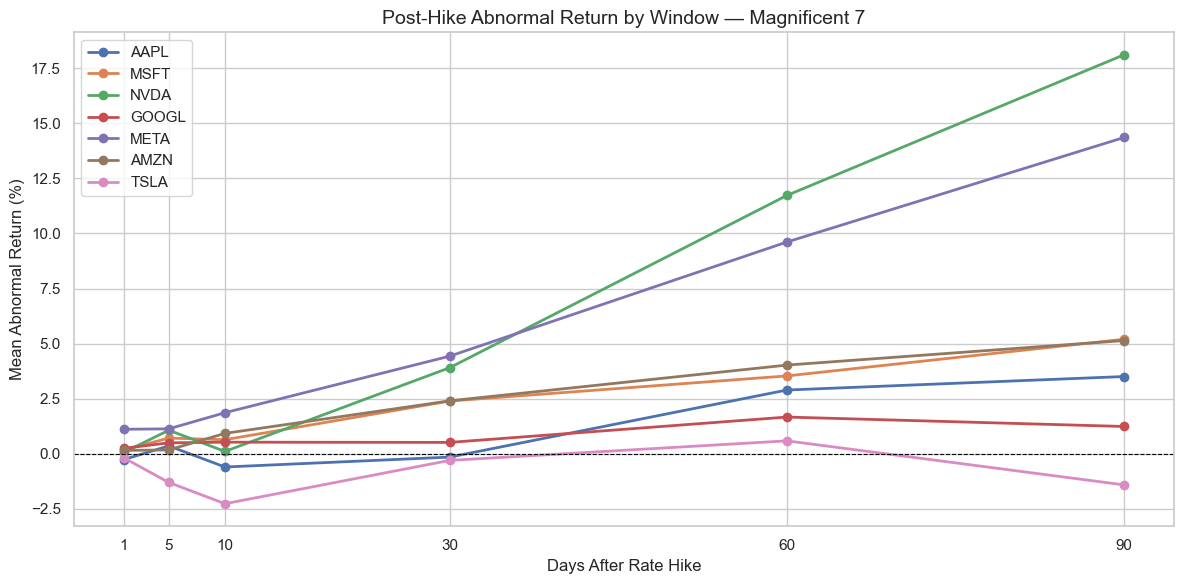

In [7]:
agg = aggregate_sensitivity(abnormal_df)

fig, ax = plt.subplots(figsize=(12, 6))

for ticker in MAG7_TICKERS:
    ticker_data = agg[agg['ticker'] == ticker].sort_values('window')
    ax.plot(ticker_data['window'], ticker_data['mean_abnormal'] * 100,
            marker='o', linewidth=2, label=ticker)

ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
ax.set_xlabel('Days After Rate Hike')
ax.set_ylabel('Mean Abnormal Return (%)')
ax.set_title('Post-Hike Abnormal Return by Window — Magnificent 7', fontsize=14)
ax.legend()
ax.set_xticks([1, 5, 10, 30, 60, 90])
plt.tight_layout()
plt.show()

## 7. Sensitivity Bar Chart (30-Day)

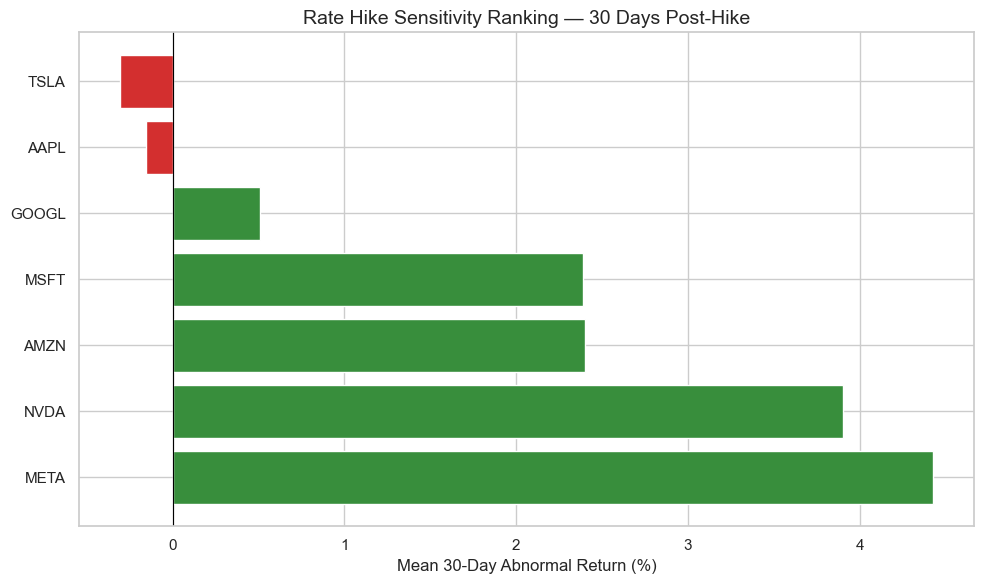

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#d32f2f' if v < 0 else '#388e3c' for v in ranking['mean_abnormal']]

bars = ax.barh(ranking['ticker'], ranking['mean_abnormal'] * 100, color=colors)

# Add significance markers
for i, (_, row) in enumerate(ranking.iterrows()):
    if row['significant_5pct']:
        ax.text(row['mean_abnormal'] * 100 - 0.3, i, '*',
                fontsize=16, fontweight='bold', va='center', ha='right' if row['mean_abnormal'] < 0 else 'left')

ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Mean 30-Day Abnormal Return (%)')
ax.set_title('Rate Hike Sensitivity Ranking — 30 Days Post-Hike', fontsize=14)
ax.invert_yaxis()  # Most sensitive at top
plt.tight_layout()
plt.show()

## 8. Consistency Across Hike Cycles

Do stocks behave the same in the 2015–18 cycle vs the 2022–23 cycle?

In [9]:
cycle_1, cycle_2 = split_by_cycle(abnormal_df)

print(f"Cycle 1 (2015-2018): {cycle_1['event_date'].nunique()} hike events")
print(f"Cycle 2 (2022-2023): {cycle_2['event_date'].nunique()} hike events")

agg_c1 = aggregate_sensitivity(cycle_1)
agg_c2 = aggregate_sensitivity(cycle_2)

# Compare 30-day abnormal returns across cycles
compare = agg_c1[agg_c1['window'] == 30][['ticker', 'mean_abnormal']].rename(
    columns={'mean_abnormal': 'cycle_1_2015_18'}
).merge(
    agg_c2[agg_c2['window'] == 30][['ticker', 'mean_abnormal']].rename(
        columns={'mean_abnormal': 'cycle_2_2022_23'}
    ),
    on='ticker',
    how='outer',
)

compare['consistent_direction'] = (
    (compare['cycle_1_2015_18'] < 0) == (compare['cycle_2_2022_23'] < 0)
)

print(f"\nStocks with consistent direction across cycles: "
      f"{compare['consistent_direction'].sum()} of {len(compare)}")
compare

Cycle 1 (2015-2018): 9 hike events
Cycle 2 (2022-2023): 11 hike events

Stocks with consistent direction across cycles: 5 of 7


,ticker,cycle_1_2015_18,cycle_2_2022_23,consistent_direction
0,AAPL,-0.006381,0.002359,False
1,AMZN,0.027626,0.021006,True
2,GOOGL,0.016387,-0.004130,False
3,META,0.048862,0.040537,True
4,MSFT,0.025830,0.022321,True
5,NVDA,0.016575,0.057433,True
6,TSLA,-0.001487,-0.004376,True


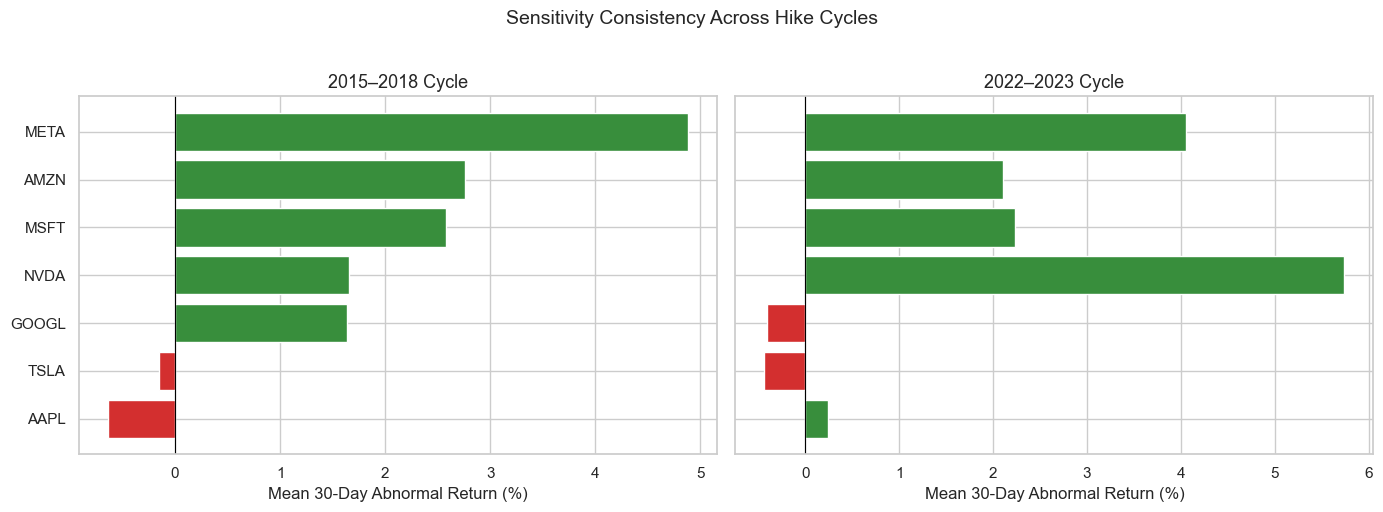

In [10]:
# Side-by-side cycle comparison chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, (label, cycle_agg) in zip(axes, [('2015–2018 Cycle', agg_c1), ('2022–2023 Cycle', agg_c2)]):
    data = cycle_agg[cycle_agg['window'] == 30].sort_values('mean_abnormal')
    colors = ['#d32f2f' if v < 0 else '#388e3c' for v in data['mean_abnormal']]
    ax.barh(data['ticker'], data['mean_abnormal'] * 100, color=colors)
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.set_title(label, fontsize=13)
    ax.set_xlabel('Mean 30-Day Abnormal Return (%)')

plt.suptitle('Sensitivity Consistency Across Hike Cycles', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Export for Tableau

In [11]:
export_sensitivity_ranking(ranking)

Exported sensitivity ranking (7 stocks) to /Users/thedarianwong/Developer/bigtech-fed-analysis/output/sensitivity_ranking.csv
